In [1]:
!pip install numpy
!pip install matplotlib
!pip install bayesian-optimization
!pip install hyperopt
!pip install pandas
!pip install scikit-learn

100%|█████████████████████████████████████████████| 200/200 [03:41<00:00,  1.11s/trial, best loss: -0.8490922405424989]
|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.8243    | 0.1309    | 8.042     | 0.5001    | 3.721     | 4.642     | 109.2     |
| 2         | 0.8323    | 0.06402   | 5.419     | 0.6984    | 5.849     | 9.546     | 168.5     |
| 3         | 0.8281    | 0.06929   | 9.147     | 0.5137    | 7.034     | 9.511     | 155.9     |
| 4         | 0.8393    | 0.05071   | 4.387     | 0.9004    | 9.714     | 7.642     | 169.2     |
| 5         | 0.817     | 0.2642    | 9.262     | 0.5425    | 1.351     | 5.057     | 187.8     |
| 6         | 0.8348    | 0.03852   | 5.948     | 0.9789    | 5.798     | 14.45     | 131.6     |
| 7         | 0.8234    | 0.2091    | 8.842     | 0.5091    | 7.751     | 19.8      | 174.8     

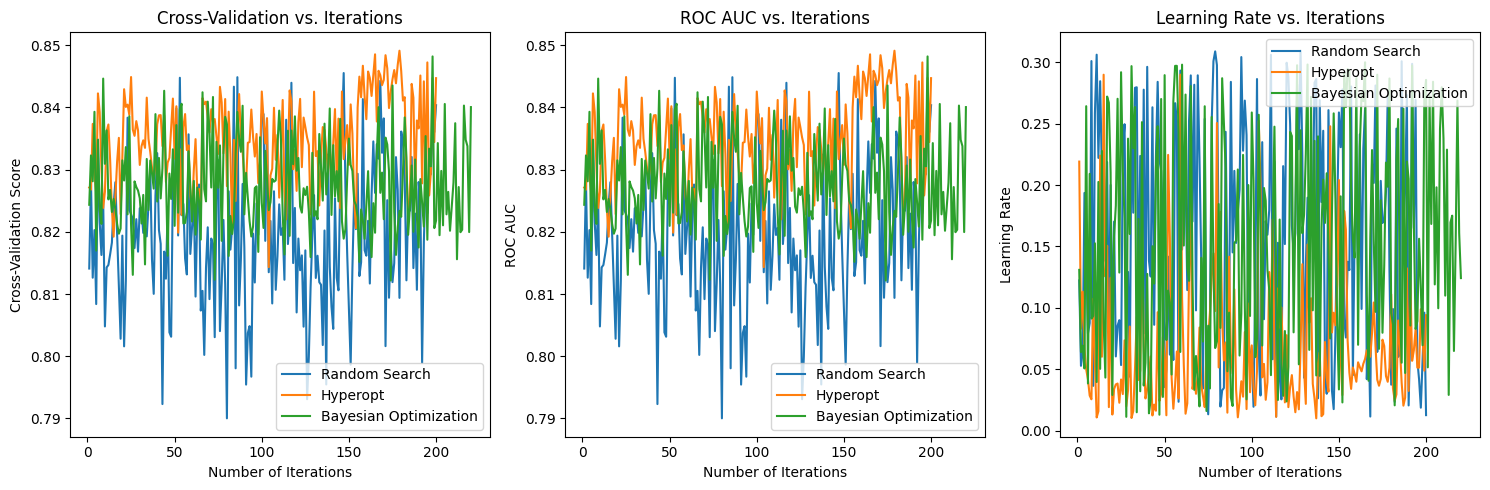

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform, randint
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
data = pd.read_csv('diabetes.csv')
X = data.drop('target', axis=1)
y = data['target']

# Define column types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Preprocessing pipelines for both numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the model pipeline
def create_pipeline(model):
    return Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Helper function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

# Randomized Search CV
def random_search_optimization():
    gbc = GradientBoostingClassifier(random_state=42)
    param_dist = {
        'classifier__n_estimators': randint(50, 500),
        'classifier__learning_rate': uniform(0.01, 0.3),
        'classifier__max_depth': randint(1, 10),
        'classifier__min_samples_split': randint(2, 20),
        'classifier__min_samples_leaf': randint(1, 20),
        'classifier__subsample': uniform(0.6, 0.4),
        'classifier__max_features': ['sqrt', 'log2', None]
    }

    pipeline = create_pipeline(gbc)
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=200, scoring='roc_auc', n_jobs=-1, cv=5, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.cv_results_

# Hyperopt optimization
def hyperopt_optimization():
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
        'n_estimators': hp.randint('n_estimators', 100, 200),
        'max_depth': hp.randint('max_depth', 3, 10),
        'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
        'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
    }

    def objective(params):
        model = GradientBoostingClassifier(
            learning_rate=params['learning_rate'],
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            min_samples_split=int(params['min_samples_split']),
            min_samples_leaf=int(params['min_samples_leaf']),
            max_features=params['max_features'],
            random_state=42
        )
        pipeline = create_pipeline(model)
        
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        roc_auc_list = []
        
        for train_index, test_index in kfold.split(X_train, y_train):
            x_train_fold, x_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
            pipeline.fit(x_train_fold, y_train_fold)
            preds_proba = pipeline.predict_proba(x_test_fold)[:, 1]
            roc_auc = roc_auc_score(y_test_fold, preds_proba)
            roc_auc_list.append(roc_auc)
        
        return {'loss': -np.mean(roc_auc_list), 'status': STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)
    best_params = {k: v if k == 'learning_rate' else int(v) for k, v in best.items()}

    final_model = GradientBoostingClassifier(**best_params, random_state=42)
    final_pipeline = create_pipeline(final_model)
    final_pipeline.fit(X_train, y_train)
    return final_pipeline, trials

# Bayesian Optimization
def bayesian_optimization():
    def bo_params_gb(learning_rate, n_estimators, max_features, min_samples_split, max_depth, min_samples_leaf):
        params = {
            'learning_rate': learning_rate,
            'max_features': max_features,
            'n_estimators': int(n_estimators),
            'min_samples_split': int(min_samples_split),
            'max_depth': int(max_depth),
            'min_samples_leaf': int(min_samples_leaf)
        }
        model = GradientBoostingClassifier(**params, random_state=42)
        pipeline = create_pipeline(model)
        
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        roc_auc_list = []
        
        for train_index, test_index in kfold.split(X_train, y_train):
            x_train_fold, x_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
            pipeline.fit(x_train_fold, y_train_fold)
            preds_proba = pipeline.predict_proba(x_test_fold)[:, 1]
            roc_auc = roc_auc_score(y_test_fold, preds_proba)
            roc_auc_list.append(roc_auc)
        
        return np.mean(roc_auc_list)

    optimizer = BayesianOptimization(
        f=bo_params_gb,
        pbounds={
            'learning_rate': (0.01, 0.3),
            'max_features': (0.5, 1),
            'n_estimators': (100, 200),
            'min_samples_split': (2, 20),
            'max_depth': (3, 10),
            'min_samples_leaf': (1, 10)
        },
        random_state=1
    )

    optimizer.maximize(init_points=20, n_iter=200)
    best_params = optimizer.max['params']
    best_params = {k: int(v) if k in ['n_estimators', 'min_samples_split', 'max_depth', 'min_samples_leaf'] else v for k, v in best_params.items()}

    final_model = GradientBoostingClassifier(**best_params, random_state=42)
    final_pipeline = create_pipeline(final_model)
    final_pipeline.fit(X_train, y_train)
    return final_pipeline, optimizer.res

# Run optimizations
random_model, random_results = random_search_optimization()
hyperopt_model, hyperopt_trials = hyperopt_optimization()
bayes_model, bayes_results = bayesian_optimization()

# Evaluate models
random_roc_auc = evaluate_model(random_model, X_test, y_test)
hyperopt_roc_auc = evaluate_model(hyperopt_model, X_test, y_test)
bayes_roc_auc = evaluate_model(bayes_model, X_test, y_test)

print(f"Random Search ROC AUC: {random_roc_auc}")
print(f"Hyperopt ROC AUC: {hyperopt_roc_auc}")
print(f"Bayesian Optimization ROC AUC: {bayes_roc_auc}")

# Plot comparison
iterations = list(range(1, 201))

# Hyperopt results extraction
hyperopt_iterations = [x['tid'] + 1 for x in hyperopt_trials.trials]
hyperopt_scores = [-x['result']['loss'] for x in hyperopt_trials.trials]

# Bayesian optimization results extraction
bayes_iterations = [i + 1 for i in range(len(bayes_results))]
bayes_scores = [x['target'] for x in bayes_results]

# Random search results extraction
random_iterations = list(range(1, len(random_results['mean_test_score']) + 1))
random_scores = random_results['mean_test_score']

plt.figure(figsize=(15, 5))

# Cross-validation vs. Number of Iterations
plt.subplot(1, 3, 1)
plt.plot(random_iterations, random_scores, label='Random Search')
plt.plot(hyperopt_iterations, hyperopt_scores, label='Hyperopt')
plt.plot(bayes_iterations, bayes_scores, label='Bayesian Optimization')
plt.xlabel('Number of Iterations')
plt.ylabel('Cross-Validation Score')
plt.legend()
plt.title('Cross-Validation vs. Iterations')

# ROC AUC vs. Number of Iterations
plt.subplot(1, 3, 2)
plt.plot(random_iterations, random_scores, label='Random Search')
plt.plot(hyperopt_iterations, hyperopt_scores, label='Hyperopt')
plt.plot(bayes_iterations, bayes_scores, label='Bayesian Optimization')
plt.xlabel('Number of Iterations')
plt.ylabel('ROC AUC')
plt.legend()
plt.title('ROC AUC vs. Iterations')

# Learning rate vs. Number of Iterations
plt.subplot(1, 3, 3)
random_learning_rates = [param['classifier__learning_rate'] for param in random_results['params']]
hyperopt_learning_rates = [trial['misc']['vals']['learning_rate'][0] for trial in hyperopt_trials.trials]
bayes_learning_rates = [res['params']['learning_rate'] for res in bayes_results]

plt.plot(random_iterations, random_learning_rates, label='Random Search')
plt.plot(hyperopt_iterations, hyperopt_learning_rates, label='Hyperopt')
plt.plot(bayes_iterations, bayes_learning_rates, label='Bayesian Optimization')
plt.xlabel('Number of Iterations')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate vs. Iterations')

plt.tight_layout()
plt.show()